# kubectl top stats (.csv) file analysis notebook
- copy the kube-top-stats .csv file to the docker mounted volume which is the directory from where you started this container
  
- make sure we have column header name as the 1st row in the below order _timeStamp,nameSpace,podName,containerName,cpuRequest,cpuUsage,memRequest,memUsage,cpuLimit,memLimit,cputhrottle,memthrottle,iothrottle,s0UtilPct,s1UtilPct,edenUtilPct,oldUtilPct,metaUtilPct,ccsUtilPct,jgcEvtCnt,jgcGcTime,fgcEvtCnt,fgcGcTime,gcS0CurrCapKb,gcS1CurrCapKb,gcS0CurrUtilKb,gcS1CurrUtilKb,gcEdenCurrCapKb,gcEdenCurrUtilKb,gcOldCurrCapKb,gcOldCurrUtilKb,gcMetaCapKb,gcMetaUtilKb,gcClassSpaceCapKb,gcClassSpaceUtilKb,gcYoungGenGcEvntCnt,gcYoungGenGcEvntTime,gcFullGcEvntCnt,gcFullGcEvntTime,gcTotGcTime,gccapMinNewGenCapKb,gccapMaxNewGenCapKb,gccapCurrNewGenCapKb,gccapMinOldGenCapKb,gccapMaxOldGenCapKb,gccapMinMetaCapKb,gccapMaxMetaCapKb,gccapMinClassSpaceCapKb,gccapMaxClassSpaceCapKb_

> *Dataframe is sensitive to whitespaces, make sure in the label and other places there are not leading/trailing whitespaces at all*


In [ ]:
import pandas as pd
import seaborn.objects as so
import seaborn as sns

file_path = 'kube-top-stats-v3.csv'
dtype_dict = {
    'timeStamp': 'string',
    'nameSpace': 'string',
    'podName': 'string',
    'containerName': 'string',
    'cpuRequest': 'float64',
    'cpuUsage': 'float64',
    'memRequest': 'float64',
    'memUsage': 'float64',
    'cpuLimit': 'float64',
    'memLimit': 'float64',
    'cputhrottle': 'float64',
    'memthrottle': 'float64',
    'iothrottle': 'float64',
    's0UtilPct': 'float64',
    's1UtilPct': 'float64',
    'edenUtilPct': 'float64',
    'oldUtilPct': 'float64',
    'metaUtilPct': 'float64',
    'ccsUtilPct': 'float64',
    'jgcEvtCnt': 'Int64',
    'jgcGcTime': 'float64',
    'fgcEvtCnt': 'Int64',
    'fgcGcTime': 'float64',
    'gcS0CurrCapKb': 'float64',
    'gcS1CurrCapKb': 'float64',
    'gcS0CurrUtilKb': 'float64',
    'gcS1CurrUtilKb': 'float64',
    'gcEdenCurrCapKb': 'float64',
    'gcEdenCurrUtilKb': 'float64',
    'gcOldCurrCapKb': 'float64',
    'gcOldCurrUtilKb': 'float64',
    'gcMetaCapKb': 'float64',
    'gcMetaUtilKb': 'float64',
    'gcClassSpaceCapKb': 'float64',
    'gcClassSpaceUtilKb': 'float64',
    'gcYoungGenGcEvntCnt': 'Int64',
    'gcYoungGenGcEvntTime': 'float64',
    'gcFullGcEvntCnt': 'Int64',
    'gcFullGcEvntTime': 'float64',
    'gcTotGcTime': 'float64',
    'gccapMinNewGenCapKb': 'float64',
    'gccapMaxNewGenCapKb': 'float64',
    'gccapCurrNewGenCapKb': 'float64',
    'gccapMinOldGenCapKb': 'float64',
    'gccapMaxOldGenCapKb': 'float64',
    'gccapMinMetaCapKb': 'float64',
    'gccapMaxMetaCapKb': 'float64',
    'gccapMinClassSpaceCapKb': 'float64',
    'gccapMaxClassSpaceCapKb': 'float64'
}

df = pd.read_csv(file_path, dtype=dtype_dict)

df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='%Y-%m-%dT%H:%M:%S')

# filter out with pod name
# df_filtered = df[df.podName.str.match('kafka-0.*',na=False)]
df_filtered = df[df.podName.str.match('.*',na=False)]

# generate a new column cpuBurstPct & memBurstPct - burstable QoS
df_filtered ['cpuBurstPct'] = 100*df_filtered['cpuLimit']/df_filtered['cpuRequest']
df_filtered ['memBurstPct'] = 100*df_filtered['memLimit']/df_filtered['memRequest']

# generate a new column cpuOveragePct & memOveragePct
df_filtered ['cpuOveragePct'] = 100*df_filtered['cpuUsage']/df_filtered['cpuRequest']
df_filtered ['memOveragePct'] = 100*df_filtered['memUsage']/df_filtered['memRequest']


## Total sampling duration

In [ ]:
df.reset_index().set_index('timeStamp',inplace=True)
print (df.timeStamp.iloc[-1] -df.timeStamp.iloc[0])

df.sample(10)

## CPU/mem allocation summary
breakup by container name

In [ ]:
# QoS - mem bursting headroom in %, which is calculated from the limit and request setting of the container
df_filtered.groupby('containerName')['memBurstPct'].max ()

In [ ]:
# QoS - cpu bursting headroom in %, which is calculated from the limit and request setting of the container
df_filtered.groupby('containerName')['cpuBurstPct'].max ()

## CPU/mem utilization summary in micore, MiB
breakup by container name

In [ ]:
# container level mem utilization metric
df_filtered.groupby('containerName')['memUsage'].describe (percentiles =[.5, .9, .95, .99])

In [ ]:
# container level cpu utilization metric
df_filtered.groupby('containerName')['cpuUsage'].describe (percentiles =[.5, .9, .95, .99])

## CPU/mem overage as % of containers.resources.requests.memory/cpu
breakup by container name

In [ ]:
# container level mem utilization overage %
df_filtered.groupby('containerName')['memOveragePct'].describe (percentiles =[.5, .9, .95, .99])

In [ ]:
# container level cpu utilization overage %
df_filtered.groupby('containerName')['cpuOveragePct'].describe (percentiles =[.5, .9, .95, .99])

## Downsampling cpuUsage, memUsage, cpuOveragePct, memOveragePct filter by a specific container
5 sec interval with aggregation function max applied

In [ ]:
# convert the index to DatetimeIndex from RangeIndex for aiding with downsampling etc
#df_downsample = df_filtered.copy()
df_downsample = df_filtered[df_filtered.podName.str.match('.*kafka.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
df_downsample = df_downsample[["cpuUsage","memUsage","cpuOveragePct", "memOveragePct"]].resample("20s").max()
# agg daily
# df_downsample = df_downsample[["cpuUsage","memUsage","cpuOveragePct", "memOveragePct"]].resample("1D").max()

df_downsample.plot(figsize=(100, 50))

## Pivot table cpuUsage, splitup by pod name & container name
Aggregation max/min/mean/count

In [ ]:
pd.set_option('display.max_columns', None)
p_table = pd.pivot_table( data=df_filtered, 
                        index=['podName'], 
                        columns=['containerName'], 
                        values='cpuUsage',
                        aggfunc=['max','min', 'mean', 'count'],
                        fill_value="None")

p_table

#p_table[p_table["cpuUsage"] > 5000]

## PSI (pressure stall information) metric - cputhrottle, memthrottle, iothrottle filter by a specific container
20 sec interval with aggregation function max applied (Downsampling)
Reference - https://www.kernel.org/doc/Documentation/accounting/psi.rst

avg10, avg60, and avg300 are average stall percentages over 10 seconds, 60 seconds, and 300 seconds respectively.
total=200ms means that since boot, tasks in the cgroup have been stalled for a cumulative total of 200 milliseconds due to I/O contention.

In [ ]:
# convert the index to DatetimeIndex from RangeIndex for aiding with downsampling etc
#df_downsample = df_filtered.copy()
df_downsample = df_filtered[df_filtered.podName.str.match('.*connect-hub.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
df_downsample = df_downsample[["cputhrottle","memthrottle","iothrottle"]].resample("20s").max()
# agg daily
# df_downsample = df_downsample[["cpuUsage","memUsage","cpuOveragePct", "memOveragePct"]].resample("1D").max()

df_downsample.plot(figsize=(100, 50))

## JVM metrics
% Utilization of various heap regions

In [ ]:
df_downsample = df_filtered[df_filtered.podName.str.match('.*connect-hub.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
# df_downsample = df_downsample[["s0UtilPct","s1UtilPct","edenUtilPct","oldUtilPct","metaUtilPct","ccsUtilPct"]].resample("20s").max()
df_downsample = df_downsample[["s0UtilPct"]].resample("20s").max()

# agg daily
# df_downsample = df_downsample[["cpuUsage","memUsage","cpuOveragePct", "memOveragePct"]].resample("1D").max()

df_downsample.plot(figsize=(100, 50))

## JVM metrics
Garbage collection metrics (metric type=counter)

jgcEvtCnt=young collection count
fgcEvtCnt=full gc count
jgcGcTime=young collection time in ms
fgcGcTime=full gc collection time ms

<Axes: xlabel='timeStamp'>

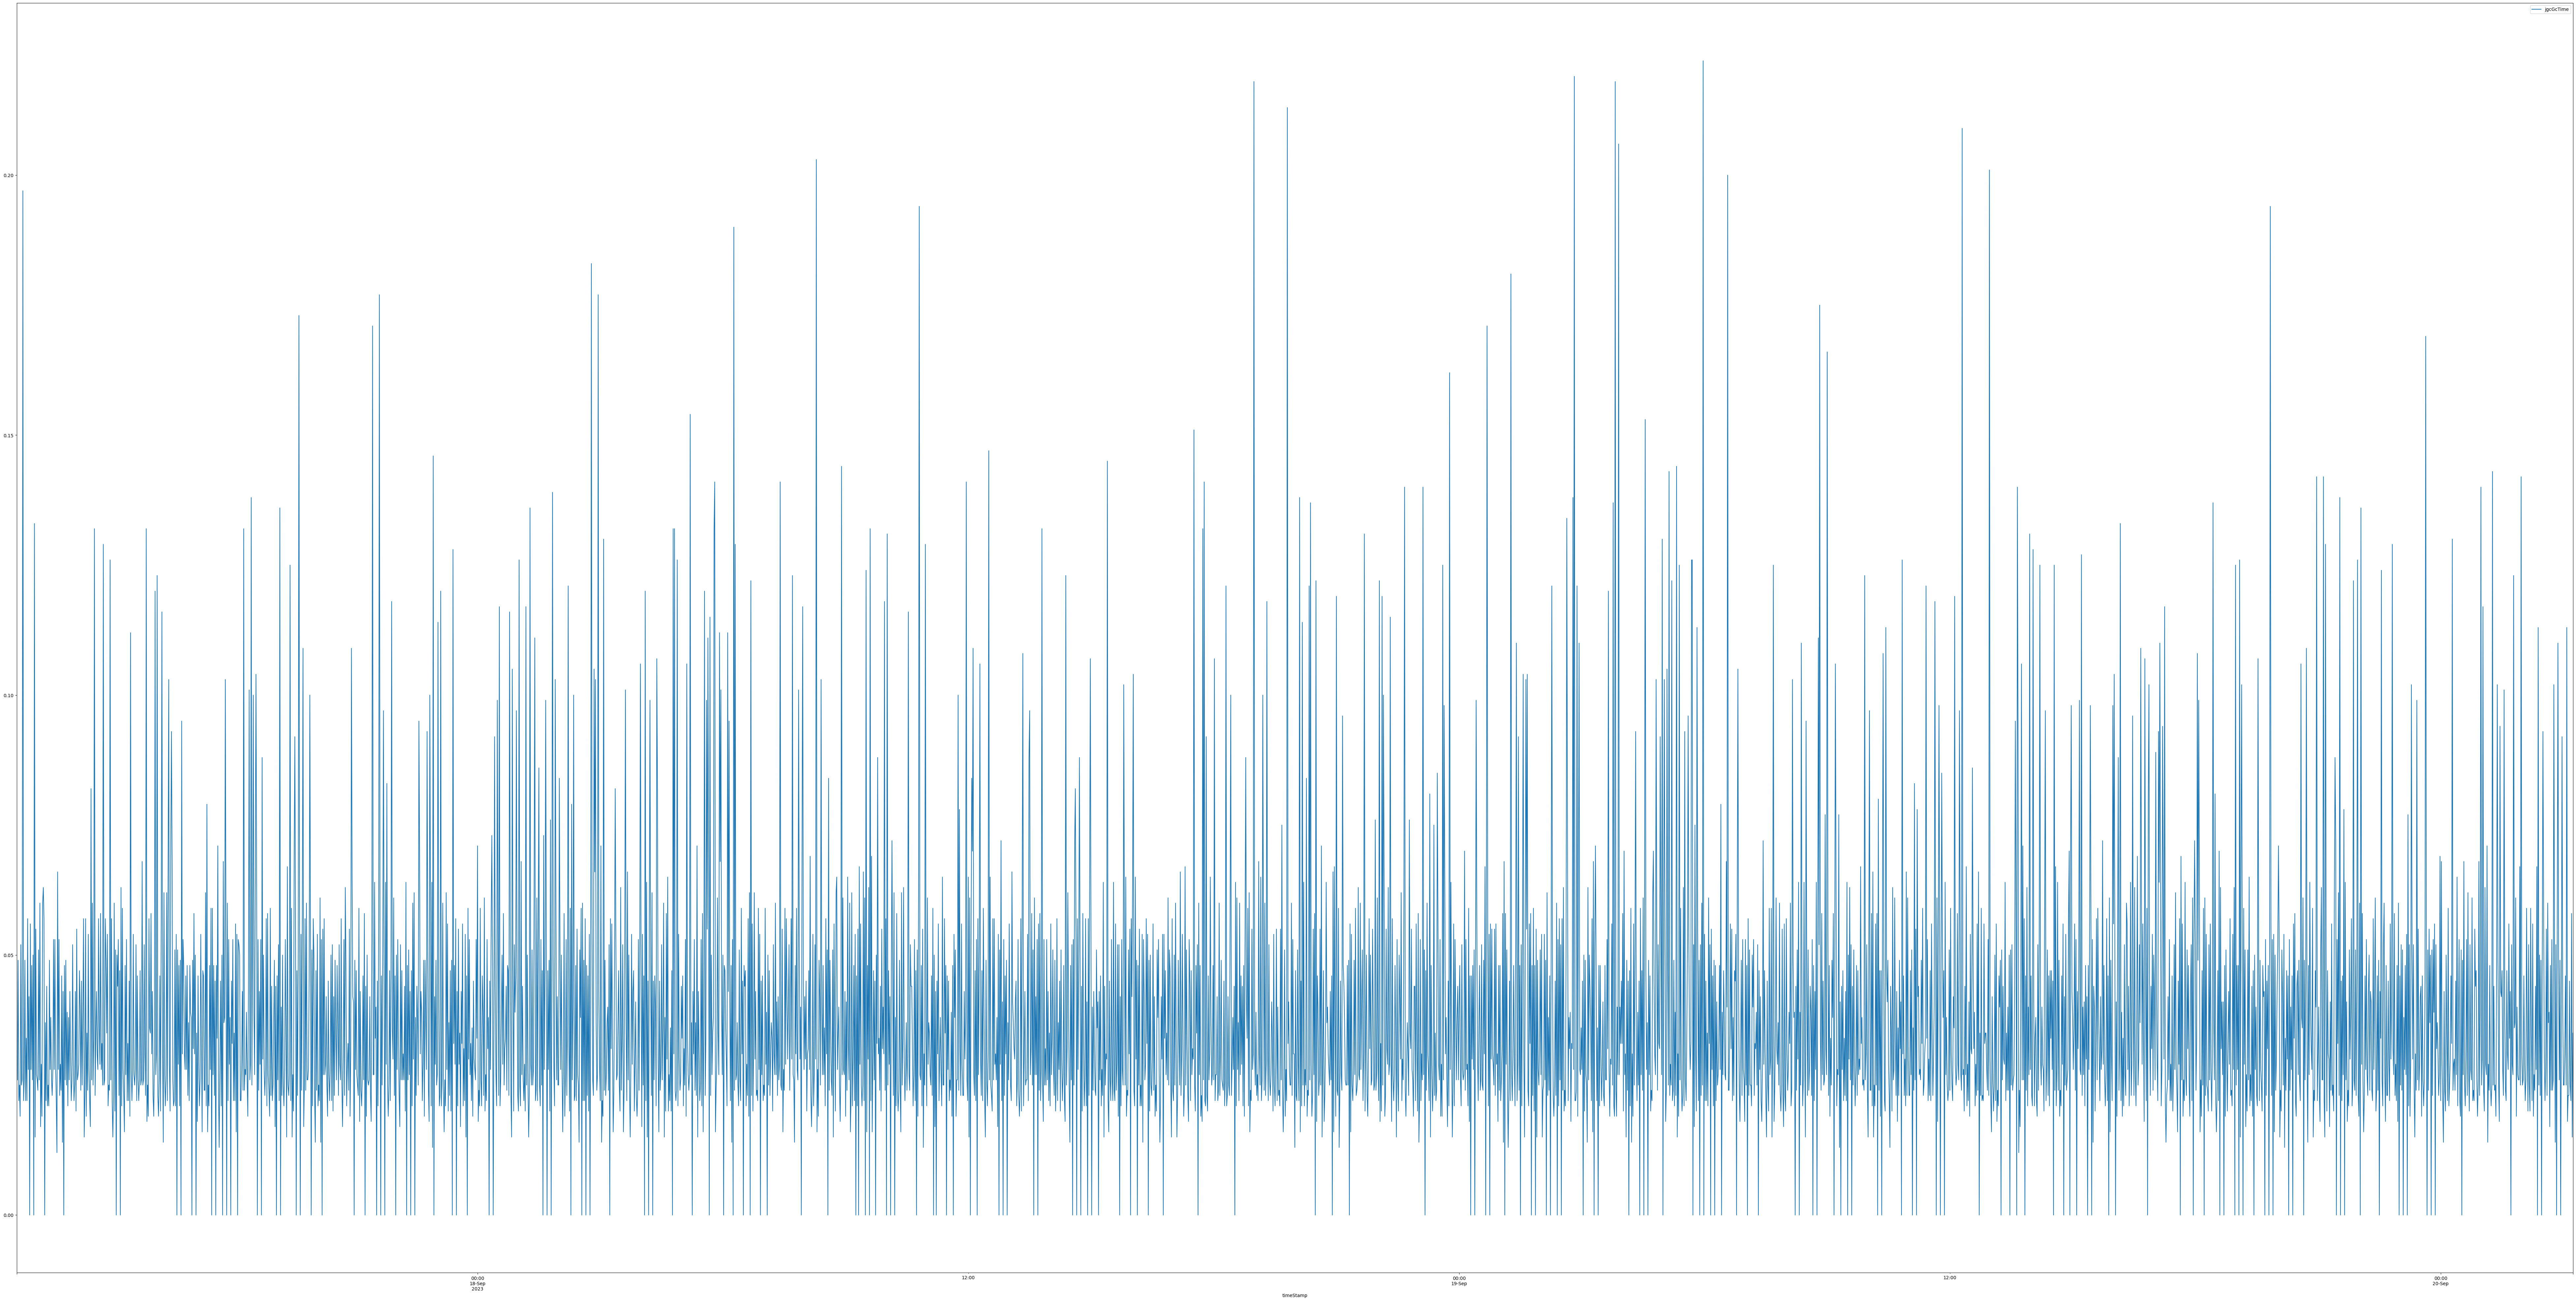

In [35]:
df_downsample = df_filtered[df_filtered.podName.str.match('.*kafka.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
# df_downsample = df_downsample[["jgcEvtCnt","jgcGcTime","fgcEvtCnt","fgcGcTime"]].resample("20s").max()
df_downsample = df_downsample[["jgcGcTime"]].resample("60s").max()

df_downsample.diff().plot(figsize=(100, 50))

## JVM metrics
Garbage collection regions size (metric type=guage)

gccapMinNewGenCapKb=new gen/eden region min size in KB
gccapMaxNewGenCapKb=new gen/eden region max size in KB 
gccapCurrNewGenCapKb=new gen/eden region current size in KB
gccapMinOldGenCapKb=old gen/tenured region min size in KB
gccapMaxOldGenCapKb=old gen/tenured region max size in KB
gccapMinMetaCapKb=meta space min size in KB
gccapMaxMetaCapKb=meta space max size in KB
gccapMinClassSpaceCapKb=class space min size in KB
gccapMaxClassSpaceCapKb=class space max size in KB


<Axes: xlabel='timeStamp'>

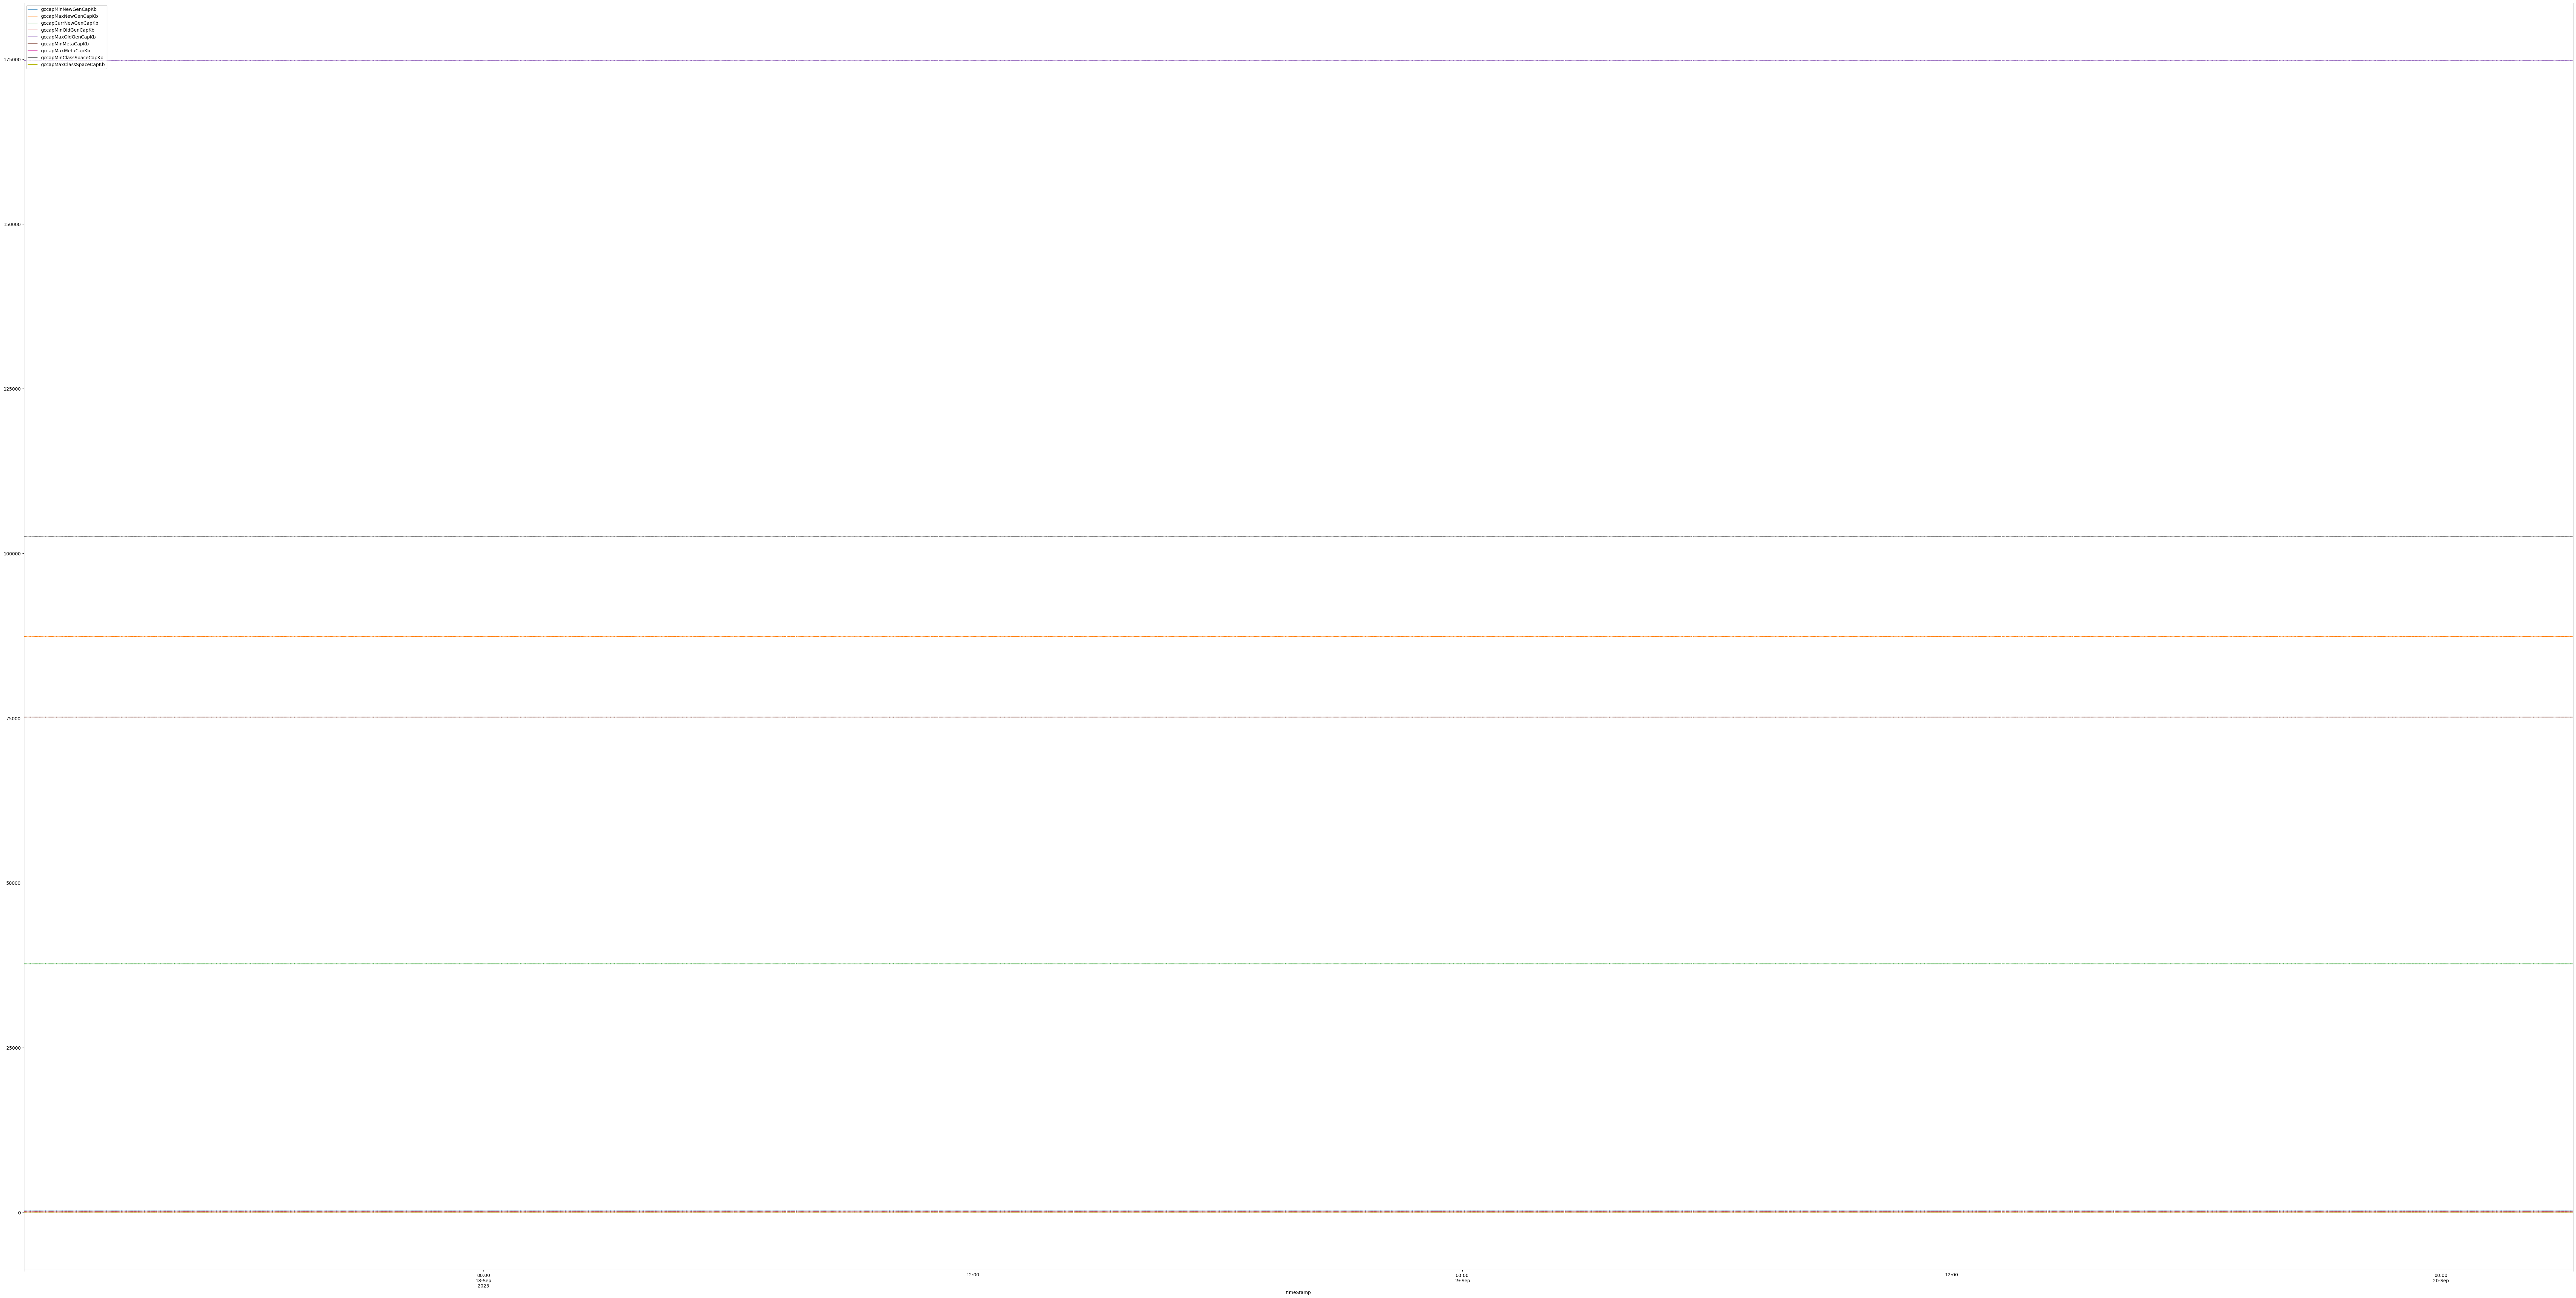

In [44]:
df_downsample = df_filtered[df_filtered.podName.str.match('.*mailbox.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
df_downsample = df_downsample[["gccapMinNewGenCapKb","gccapMaxNewGenCapKb","gccapCurrNewGenCapKb","gccapMinOldGenCapKb","gccapMaxOldGenCapKb","gccapMinMetaCapKb","gccapMaxMetaCapKb","gccapMinClassSpaceCapKb","gccapMaxClassSpaceCapKb"]].resample("20s").max()
#df_downsample = df_downsample[["gccapMaxNewGenCapKb"]].resample("20s").max()

df_downsample.plot(figsize=(100, 50))

In [ ]:
## JVM metrics
Garbage collection regions used sizes (metric type=guage)

gcS0CurrCapKb=s0 space current capacity in KB (this is more a threshold, based on jvm setting and hurestics this will get recalculated )
gcS1CurrCapKb=s1 space current capacity in KB (this is more a threshold, based on jvm setting and hurestics this will get recalculated )
gcS0CurrUtilKb=s0 space current used size in KB
gcS1CurrUtilKb=s1 space current used size in KB
gcEdenCurrCapKb=eden space current capacity in KB (this is more a threshold, based on jvm setting and hurestics this will get recalculated )
gcEdenCurrUtilKb=eden space current used size in KB 
gcOldCurrCapKb=old gen current capacity in KB (this is more a threshold, based on jvm setting and hurestics this will get recalculated )
gcOldCurrUtilKb=old gen current used size in KB
gcMetaCapKb=meta space current capacity in KB (this is more a threshold, based on jvm setting and hurestics this will get recalculated )
gcMetaUtilKb=meta space current used size in KB
gcClassSpaceCapKb=class space current capacity in KB (this is more a threshold, based on jvm setting and hurestics this will get recalculated )
gcClassSpaceUtilKb=class space current used size in KB


<Axes: xlabel='timeStamp'>

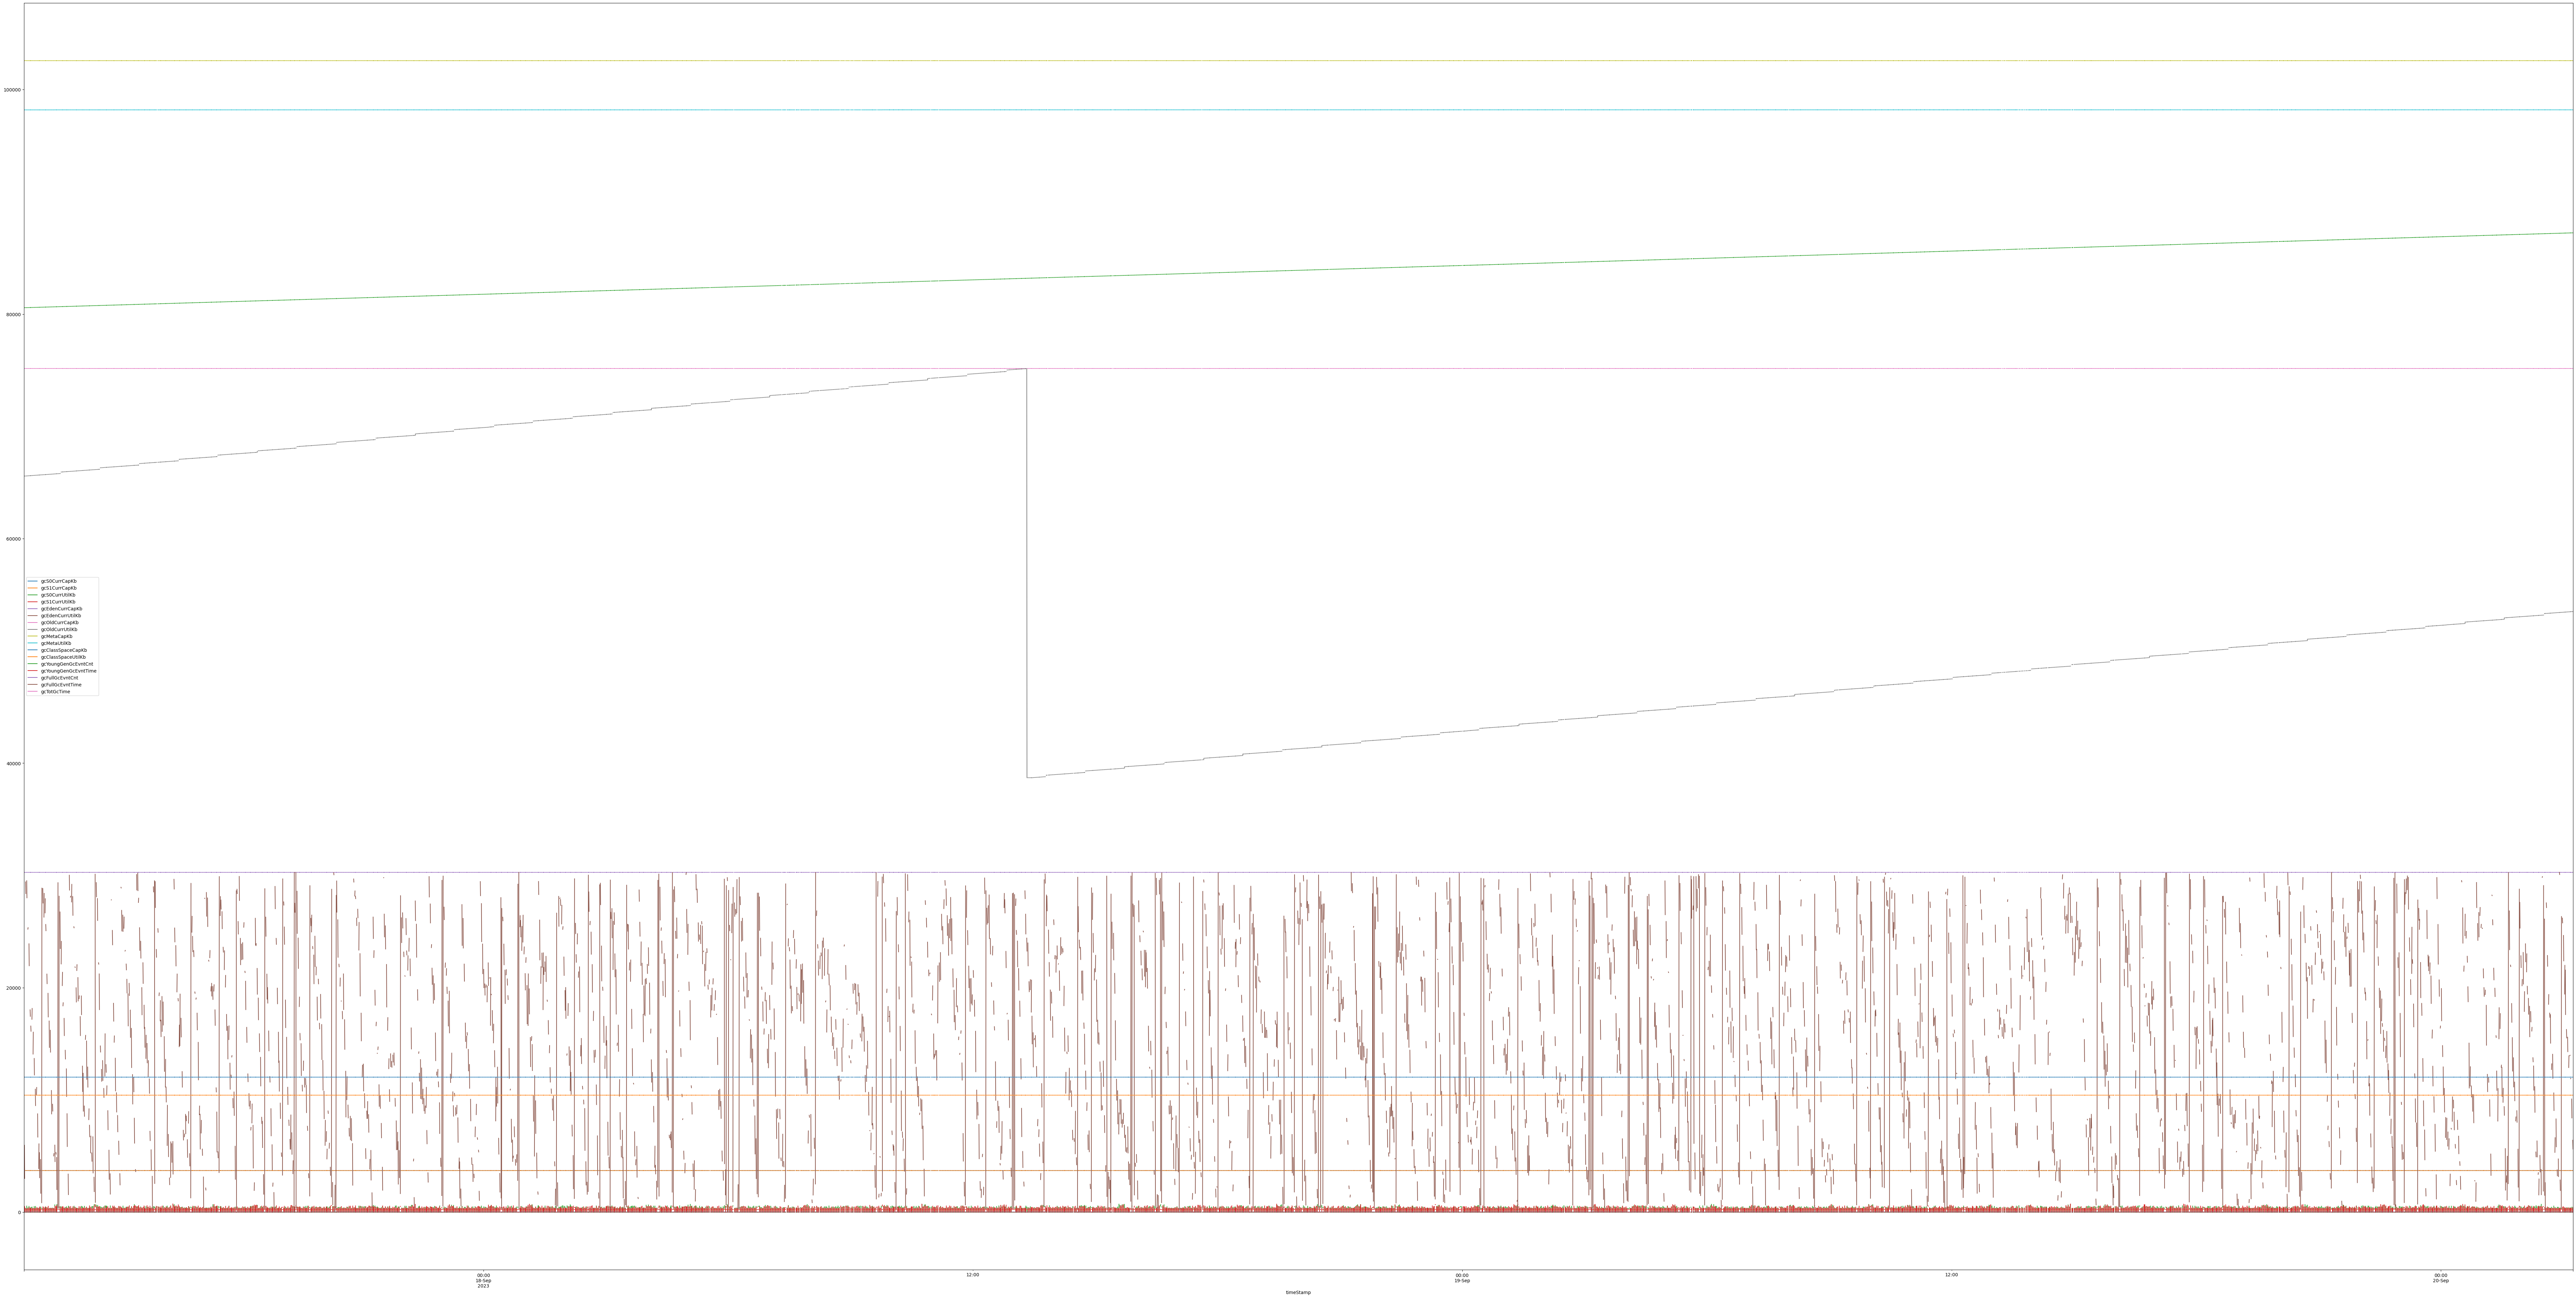

In [45]:
df_downsample = df_filtered[df_filtered.podName.str.match('.*mailbox.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
df_downsample = df_downsample[["gcS0CurrCapKb","gcS1CurrCapKb","gcS0CurrUtilKb","gcS1CurrUtilKb","gcEdenCurrCapKb","gcEdenCurrUtilKb","gcOldCurrCapKb","gcOldCurrUtilKb","gcMetaCapKb","gcMetaUtilKb","gcClassSpaceCapKb","gcClassSpaceUtilKb"]].resample("20s").max()
#df_downsample = df_downsample[["gccapMaxNewGenCapKb"]].resample("20s").max()

df_downsample.plot(figsize=(100, 50))

## JVM metrics
Garbage collection events stats (metric type=counter)

gcYoungGenGcEvntCnt=young gc event count
gcYoungGenGcEvntTime=young gc event time in ms
gcFullGcEvntCnt=full gc event count
gcFullGcEvntTime=full gc event time in ms
gcTotGcTime=total gc time in ms


In [57]:
df_downsample = df_filtered[df_filtered.podName.str.match('.*mailbox.*',na=False)]
df_downsample.set_index('timeStamp',inplace=True)

# agg 5sec
df_downsample = df_downsample[["gcYoungGenGcEvntCnt","gcYoungGenGcEvntTime","gcFullGcEvntCnt","gcFullGcEvntTime","gcTotGcTime"]].resample("20s").max()
#df_downsample = df_downsample[["gccapMaxNewGenCapKb"]].resample("20s").max()

#df_downsample.diff().plot(kind='bar',figsize=(100, 50))
df_downsample.diff().sample(10)

gcYoungGenGcEvntCnt  gcYoungGenGcEvntTime  \
timeStamp                                                        
2023-09-18 21:34:00                    1                 0.003   
2023-09-19 07:17:40                 <NA>                   NaN   
2023-09-18 12:27:40                    1                 0.004   
2023-09-18 13:55:20                 <NA>                   NaN   
2023-09-19 22:27:00                 <NA>                   NaN   
2023-09-19 10:54:00                 <NA>                   NaN   
2023-09-19 04:51:20                 <NA>                   NaN   
2023-09-19 21:29:20                    1                 0.003   
2023-09-19 23:22:00                 <NA>                   NaN   
2023-09-17 21:46:20                 <NA>                   NaN   

                     gcFullGcEvntCnt  gcFullGcEvntTime  gcTotGcTime  
timeStamp                                                            
2023-09-18 21:34:00                0               0.0          NaN  
2023-09-19 07:17:40             <NA>               NaN          NaN  
2023-09-18 12:27:40                0               0.0          NaN  
2023-09-18 13:55:20             <NA>               NaN          NaN  
2023-09-19 22:27:00             <NA>               NaN          NaN  
2023-09-19 10:54:00             <NA>               NaN          NaN  
2023-09-19 04:51:20             <NA>               NaN          NaN  
2023-09-19 21:29:20                0               0.0          NaN  
2023-09-19 23:22:00             <NA>               NaN          NaN  
2023-09-17 21:46:20             <NA>               NaN          NaN